In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import numpyro
import jax
import jax.numpy as jnp
import corner
from iminuit import Minuit
from scipy.optimize import minimize
import joblib
import arviz as az

import os
num_chains=5
os.environ['XLA_FLAGS']= f'--xla_force_host_platform_device_count={num_chains}'
numpyro.set_platform('cpu')
numpyro.set_host_device_count(f'{num_chains}')

rc = {
    "plot.max_subplots": 30,
}
az.rcParams.update(rc)

/home/ljf1/dis/orrery/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# a

In [2]:
data = pd.read_csv('src/1-Fragment_C_Hole_Measurements.csv')
file_path = 'src'

In [3]:
data

Section ID  Hole  Inter-hole Distance    Mean(X)   Mean(Y)
0            0     1                  NaN   15.59931  92.59653
1            1     2                  NaN   16.44167  91.50069
2            1     3             1.440694   17.30764  90.34931
3            1     4             1.456973   18.15278  89.16250
4            1     5             1.299821   18.96528  88.14792
..         ...   ...                  ...        ...       ...
76           7    77             1.259985  108.69444  63.42778
77           7    78             1.430105  110.05486  63.86875
78           7    79             1.179606  111.14583  64.31736
79           7    80             1.428043  112.48021  64.82604
80           7    81             1.259015  113.64028  65.31528

[81 rows x 5 columns]

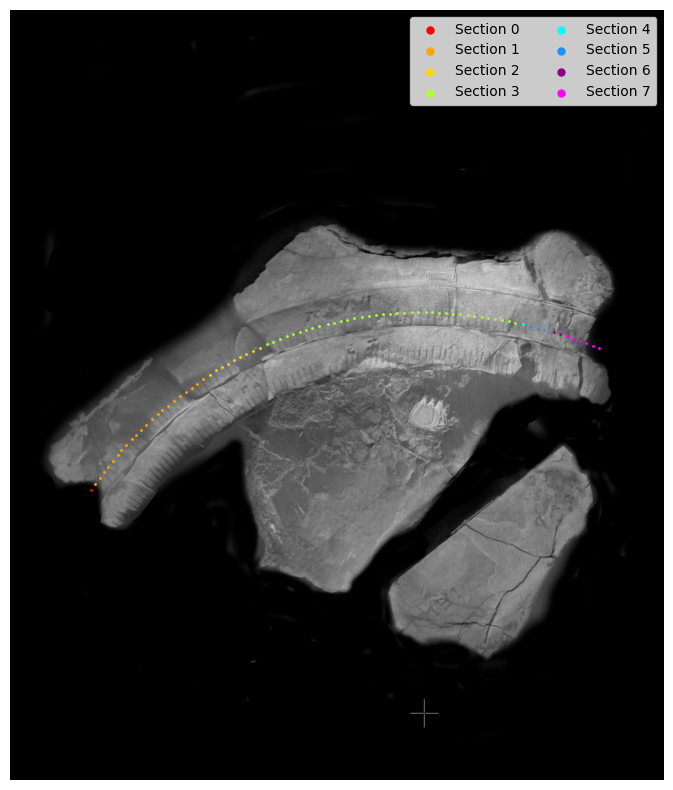

In [4]:
img = mpimg.imread(f'{file_path}/3-Figure-2-Engraved_Lines_with_Center.jpg')
fig, ax = plt.subplots(figsize=(10, 10))
colors = ["red", "orange", "gold", "greenyellow", "aqua", "dodgerblue", "darkmagenta", "fuchsia"]
ax.imshow(img, cmap='Grays_r')
for i in range(max(data['Section ID'].unique()+1)):
  section_data = data[data['Section ID'] == i]
  ax.scatter(section_data['Mean(X)']*20, section_data['Mean(Y)']*20, s = 1, color=colors[i], label=f"Section {i}")
plt.legend(ncol=2, markerscale=5)
ax.axis('off')
plt.show()

# b

In [5]:
data['Section ID'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [6]:
new_data = data[~data['Section ID'].isin([0, 4])]
sections = new_data['Section ID'].unique()
n = len(new_data['Hole'].values)
s = len(sections)
hole_ids = new_data['Hole'].values
section_ids = new_data['Section ID'].values
section_data = {section: new_data[new_data['Section ID'] == section] for section in sections}
data_vec = jnp.vstack((new_data['Mean(X)'].values, new_data['Mean(Y)'].values)).T
holes_in_section = jnp.array([len(section_data[section]) for section in sections])

In [7]:
remap_dict = {1: 0, 2: 1, 3: 2, 5: 3, 6: 4, 7: 5}
vectorized_remap = np.vectorize(lambda x: remap_dict.get(x, x))
remapped_section_ids = vectorized_remap(section_ids)

In [8]:
N_range = jnp.array([300, 400])
r_range = jnp.array([50, 100])
x_range = jnp.array([70, 85])
y_range = jnp.array([100, 150])
sigma_range = jnp.array([0, 1])
alpha_range = jnp.array([0, 2*jnp.pi])

In [9]:
#just the model for the hole positions in cartesian and polar coordinates as defined by the paper
def paper_model(r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7):
  x0 = jnp.array([x1, x2, x3, x5, x6, x7])
  y0 = jnp.array([y1, y2, y3, y5, y6, y7])
  alpha = jnp.array([alpha1, alpha2, alpha3, alpha5, alpha6, alpha7])
  
  x0s = jnp.repeat(x0, holes_in_section, total_repeat_length=n)
  y0s = jnp.repeat(y0, holes_in_section, total_repeat_length=n)
  alphas = jnp.repeat(alpha, holes_in_section, total_repeat_length=n)
  phi = 2*jnp.pi*(jnp.arange(jnp.sum(holes_in_section)) - 1) / N + alphas

  r_ij = jnp.vstack((r*jnp.cos(phi), r*jnp.sin(phi))).T
  r0_ij = jnp.vstack((x0s, y0s)).T

  cartesian = r_ij + r0_ij
  radial = jnp.sqrt(r_ij[:, 0]**2 + r_ij[:, 1]**2)
  theta = jnp.arctan2(r_ij[:, 1], r_ij[:, 0])
  polar = jnp.vstack((radial, theta)).T

  return jnp.stack((cartesian, polar), axis=1), phi

In [10]:
def isonll(params, data):
  n = len(data)

  r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma = params
  x0 = jnp.array([x1, x2, x3, x5, x6, x7])
  y0 = jnp.array([y1, y2, y3, y5, y6, y7])
  alpha = jnp.array([alpha1, alpha2, alpha3, alpha5, alpha6, alpha7])

  x0s = jnp.repeat(x0, holes_in_section)
  y0s = jnp.repeat(y0, holes_in_section)
  alphas = jnp.repeat(alpha, holes_in_section)

  phi = 2*jnp.pi*(jnp.arange(n) - 1)/N + alphas
  coeff = -n*jnp.log(2*jnp.pi*sigma**2) #isotropic

  phi = 2*jnp.pi*(hole_ids - 1) / N + alphas

  x = data[:,0] - x0s - r*jnp.cos(phi)
  y = data[:,1] - y0s - r*jnp.sin(phi)

  return -(coeff - jnp.sum((x*jnp.cos(phi)+y*jnp.sin(phi))**2 + (-x*jnp.sin(phi)-y*jnp.cos(phi))**2)/(2*sigma**2))

def anisonll(params, data):
  n = len(data)

  r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma_r, sigma_t = params
  x0 = jnp.array([x1, x2, x3, x5, x6, x7])
  y0 = jnp.array([y1, y2, y3, y5, y6, y7])
  alpha = jnp.array([alpha1, alpha2, alpha3, alpha5, alpha6, alpha7])

  x0s = jnp.repeat(x0, holes_in_section)
  y0s = jnp.repeat(y0, holes_in_section)
  alphas = jnp.repeat(alpha, holes_in_section)

  phi = 2*jnp.pi*(jnp.arange(n) - 1)/N + alphas
  coeff = -n*jnp.log(2*jnp.pi*sigma_r*sigma_t)

  phi = 2*jnp.pi*(hole_ids - 1) / N + alphas

  x = data[:,0] - x0s - r*jnp.cos(phi)
  y = data[:,1] - y0s - r*jnp.sin(phi)

  return -(coeff - jnp.sum(
                          ((x*jnp.cos(phi)+y*jnp.sin(phi))**2)/(2*sigma_r**2) + 
                          ((-x*jnp.sin(phi)-y*jnp.cos(phi))**2)/(2*sigma_t**2)
                          ))

In [11]:
def iso_neg_log_likelihood(r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma):
  """ Negative log-likelihood function to minimize. """
  params = r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma
  return isonll(params, data_vec)

def aniso_neg_log_likelihood(r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma_r, sigma_t):
  """ Negative log-likelihood function to minimize. """
  params = r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma_r, sigma_t
  return anisonll(params, data_vec)

In [12]:
def iso_likelihood(params, data):
    n = len(data)

    r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma = params
    x0 = jnp.array([x1, x2, x3, x5, x6, x7])
    y0 = jnp.array([y1, y2, y3, y5, y6, y7])
    alpha = jnp.array([alpha1, alpha2, alpha3, alpha5, alpha6, alpha7])

    x0s = jnp.repeat(x0, holes_in_section)
    y0s = jnp.repeat(y0, holes_in_section)
    alphas = jnp.repeat(alpha, holes_in_section)

    phi = 2*jnp.pi*(jnp.arange(n) - 1)/N + alphas
    coeff = -n*jnp.log(2*jnp.pi*sigma**2) #isotropic

    phi = 2*jnp.pi*(hole_ids - 1) / N + alphas

    x = data[:,0] - x0s - r*jnp.cos(phi)
    y = data[:,1] - y0s - r*jnp.sin(phi)

    return jnp.exp(coeff - jnp.sum((x*jnp.cos(phi)+y*jnp.sin(phi))**2 + (-x*jnp.sin(phi)-y*jnp.cos(phi))**2)/(2*sigma**2))

def aniso_likelihood(params, data):
  n = len(data)

  r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma_r, sigma_t = params
  x0 = jnp.array([x1, x2, x3, x5, x6, x7])
  y0 = jnp.array([y1, y2, y3, y5, y6, y7])
  alpha = jnp.array([alpha1, alpha2, alpha3, alpha5, alpha6, alpha7])

  x0s = jnp.repeat(x0, holes_in_section)
  y0s = jnp.repeat(y0, holes_in_section)
  alphas = jnp.repeat(alpha, holes_in_section)

  phi = 2*jnp.pi*(jnp.arange(n) - 1)/N + alphas
  coeff = -n*jnp.log(2*jnp.pi*sigma_r*sigma_t)

  phi = 2*jnp.pi*(hole_ids - 1) / N + alphas

  x = data[:,0] - x0s - r*jnp.cos(phi)
  y = data[:,1] - y0s - r*jnp.sin(phi)

  return jnp.exp(coeff - jnp.sum(
                          ((x*jnp.cos(phi)+y*jnp.sin(phi))**2)/(2*sigma_r**2) + 
                          ((-x*jnp.sin(phi)-y*jnp.cos(phi))**2)/(2*sigma_t**2)
                          ))

# e

In [13]:
r = 77.34
N = 355.1
sigma = 1
x = jnp.array([79.69, 79.91, 79.86, 81.44, 81.56, 83.22])
y = jnp.array([136.03, 135.71, 135.71, 136.10, 135.855, 136.42])
alpha = np.radians([-145.72, -145.67, -145.54, -146.71, -146.36, -147.80])
params_iso = jnp.array([r, N, *x, *y, *alpha, sigma], dtype=jnp.float32)
params_aniso = jnp.array([r, N, *x, *y, *alpha, sigma, sigma], dtype=jnp.float32)

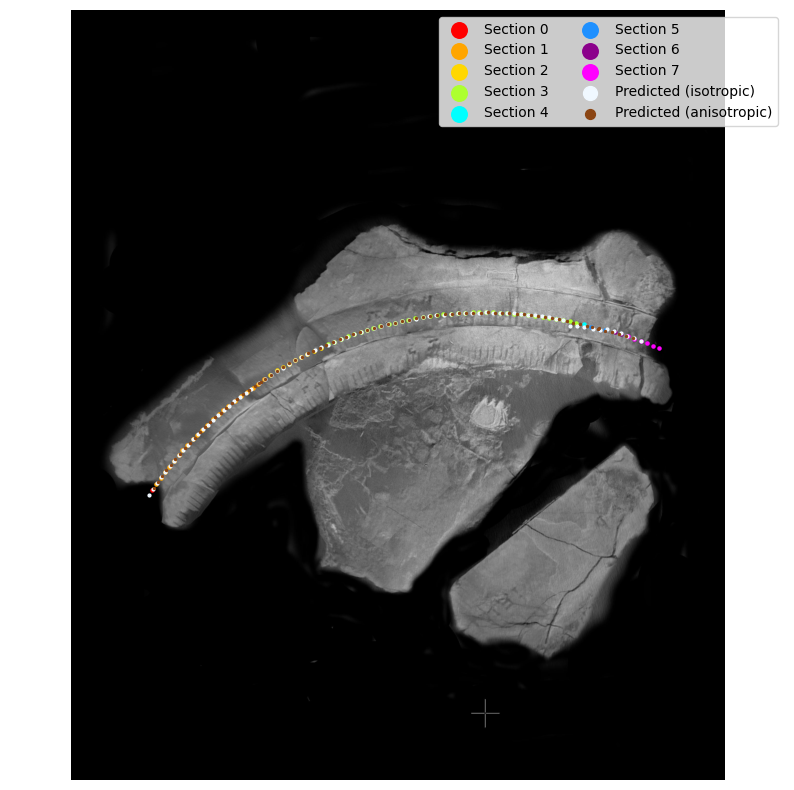

In [14]:
result_iso = minimize(isonll, params_iso, args=(data_vec,), method='Nelder-Mead')
result_aniso = minimize(anisonll, params_aniso, args=(data_vec), method='Nelder-Mead')
isomodel_data, phi = paper_model(*result_iso.x[:-1])
anisomodel_data, phi = paper_model(*result_aniso.x[:-2])
fig, ax = plt.subplots(figsize=(10, 10))
colors = ["red", "orange", "gold", "greenyellow", "aqua", "dodgerblue", "darkmagenta", "fuchsia"]
ax.imshow(img, cmap='Grays_r')
for i in range(max(data['Section ID'].unique()+1)):
  section_data = data[data['Section ID'] == i]
  ax.scatter(section_data['Mean(X)']*20, section_data['Mean(Y)']*20, s = 5, color=colors[i], label=f"Section {i}")
ax.scatter(isomodel_data[:, 0, 0]*20, isomodel_data[:, 0, 1]*20, s=4, color="aliceblue", label="Predicted (isotropic)")
ax.scatter(anisomodel_data[:, 0, 0]*20, anisomodel_data[:, 0, 1]*20, s=2, color="saddlebrown", label="Predicted (anisotropic)")
plt.legend(ncol=2, markerscale=5)
ax.axis('off')
ax.axis('equal')
plt.show()

In [15]:
result_iso.x

array([ 7.8326920e+01,  3.6075897e+02,  8.0233948e+01,  8.1773346e+01,
        8.0074997e+01,  9.1813400e+01,  9.1795395e+01,  8.1406677e+01,
        1.3693216e+02,  1.3580429e+02,  1.3671146e+02,  1.3917731e+02,
        1.3947394e+02,  1.3675156e+02, -2.5372939e+00, -2.5558643e+00,
       -2.5283132e+00, -2.6795511e+00, -2.6738634e+00, -2.5384936e+00,
        6.7277238e-02], dtype=float32)

In [16]:
result_aniso.x

array([ 7.8510239e+01,  3.5422559e+02,  8.0531158e+01,  8.0677704e+01,
        7.9941071e+01,  8.1476974e+01,  8.4655457e+01,  8.4351440e+01,
        1.3689435e+02,  1.3663406e+02,  1.3690024e+02,  1.3733807e+02,
        1.3802017e+02,  1.3809708e+02, -2.5187345e+00, -2.5452185e+00,
       -2.5394368e+00, -2.5613699e+00, -2.6078854e+00, -2.6232367e+00,
        3.0789189e-02,  1.0958645e+00], dtype=float32)

# f

In [17]:
def isomodel(d):
    N = numpyro.sample("N", numpyro.distributions.Uniform(N_range[0], N_range[1]))
    r = numpyro.sample("r", numpyro.distributions.Uniform(r_range[0], r_range[1]))
    sigma = numpyro.sample("sigma", numpyro.distributions.Uniform(sigma_range[0], sigma_range[1]))

    x0_1 = numpyro.sample('x0_1', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_2 = numpyro.sample('x0_2', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_3 = numpyro.sample('x0_3', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_5 = numpyro.sample('x0_5', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_6 = numpyro.sample('x0_6', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_7 = numpyro.sample('x0_7', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    
    y0_1 = numpyro.sample('y0_1', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_2 = numpyro.sample('y0_2', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_3 = numpyro.sample('y0_3', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_5 = numpyro.sample('y0_5', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_6 = numpyro.sample('y0_6', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_7 = numpyro.sample('y0_7', numpyro.distributions.Uniform(y_range[0], y_range[1]))

    alpha_1 = numpyro.sample('alpha_1', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_2 = numpyro.sample('alpha_2', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_3 = numpyro.sample('alpha_3', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_5 = numpyro.sample('alpha_5', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_6 = numpyro.sample('alpha_6', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_7 = numpyro.sample('alpha_7', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))

    x0 = jnp.array([x0_1, x0_2, x0_3, x0_5, x0_6, x0_7])
    y0 = jnp.array([y0_1, y0_2, y0_3, y0_5, y0_6, y0_7])
    alphas = jnp.array([alpha_1, alpha_2, alpha_3, alpha_5, alpha_6, alpha_7])
    
    phis = 2*jnp.pi*(hole_ids-1)/N + alphas[remapped_section_ids]

    cos_phis = jnp.cos(phis)
    sin_phis = jnp.sin(phis)

    xij = r * cos_phis + x0[remapped_section_ids]
    yij = r * sin_phis + y0[remapped_section_ids]

    ex = xij - d[:,0]
    ey = yij - d[:,1]

    er = ex * cos_phis + ey * sin_phis
    et = -ex * sin_phis + ey * cos_phis 

    error = jnp.stack([er, et], axis = 1)

    covariance_matrix = jnp.array([
        [sigma * sigma, 0],
        [0, sigma * sigma]
    ])
    
    with numpyro.plate("data", len(d)):
        numpyro.sample("obs", numpyro.distributions.MultivariateNormal(jnp.zeros(2), covariance_matrix=covariance_matrix), obs=error)

In [18]:
def anisomodel(d):
    N = numpyro.sample("N", numpyro.distributions.Uniform(N_range[0], N_range[1]))
    r = numpyro.sample("r", numpyro.distributions.Uniform(r_range[0], r_range[1]))
    sigma_r = numpyro.sample("sigma_r", numpyro.distributions.Uniform(sigma_range[0], sigma_range[1]))
    sigma_t = numpyro.sample("sigma_t", numpyro.distributions.Uniform(sigma_range[0], sigma_range[1]))

    x0_1 = numpyro.sample('x0_1', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_2 = numpyro.sample('x0_2', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_3 = numpyro.sample('x0_3', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_5 = numpyro.sample('x0_5', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_6 = numpyro.sample('x0_6', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    x0_7 = numpyro.sample('x0_7', numpyro.distributions.Uniform(x_range[0], x_range[1]))
    
    y0_1 = numpyro.sample('y0_1', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_2 = numpyro.sample('y0_2', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_3 = numpyro.sample('y0_3', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_5 = numpyro.sample('y0_5', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_6 = numpyro.sample('y0_6', numpyro.distributions.Uniform(y_range[0], y_range[1]))
    y0_7 = numpyro.sample('y0_7', numpyro.distributions.Uniform(y_range[0], y_range[1]))

    alpha_1 = numpyro.sample('alpha_1', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_2 = numpyro.sample('alpha_2', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_3 = numpyro.sample('alpha_3', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_5 = numpyro.sample('alpha_5', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_6 = numpyro.sample('alpha_6', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))
    alpha_7 = numpyro.sample('alpha_7', numpyro.distributions.Uniform(alpha_range[0], alpha_range[1]))

    x0 = jnp.array([x0_1, x0_2, x0_3, x0_5, x0_6, x0_7])
    y0 = jnp.array([y0_1, y0_2, y0_3, y0_5, y0_6, y0_7])
    alphas = jnp.array([alpha_1, alpha_2, alpha_3, alpha_5, alpha_6, alpha_7])
    
    phis = 2*jnp.pi*(hole_ids-1)/N + alphas[remapped_section_ids]

    cos_phis = jnp.cos(phis)
    sin_phis = jnp.sin(phis)

    xij = r * cos_phis + x0[remapped_section_ids]
    yij = r * sin_phis + y0[remapped_section_ids]

    ex = xij - d[:,0]
    ey = yij - d[:,1]

    er = ex * cos_phis + ey * sin_phis
    et = -ex * sin_phis + ey * cos_phis 

    error = jnp.stack([er, et], axis = 1)

    covariance_matrix = jnp.array([
        [sigma_r * sigma_t, 0],
        [0, sigma_r * sigma_t]
    ])
    
    with numpyro.plate("data", len(d)):
        numpyro.sample("obs", numpyro.distributions.MultivariateNormal(jnp.zeros(2), covariance_matrix=covariance_matrix), obs=error)

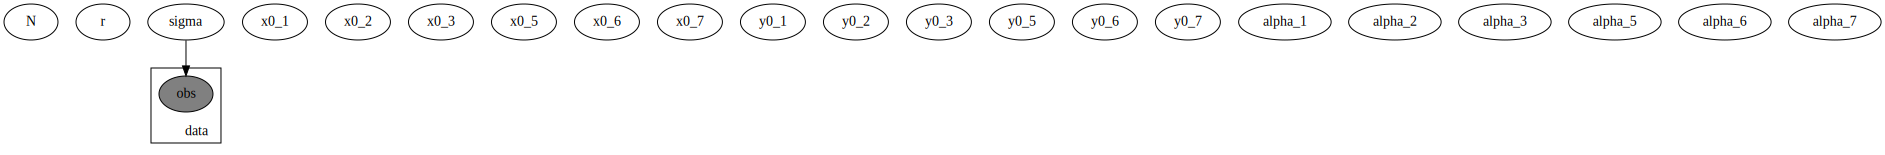

In [19]:
numpyro.render_model(isomodel, model_args=(data_vec,))

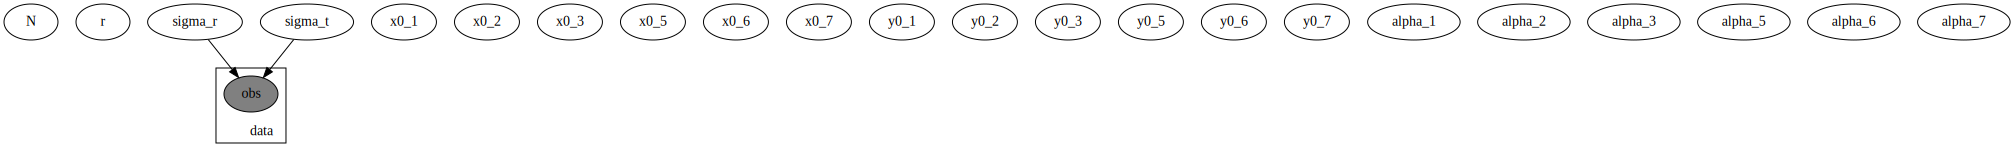

In [20]:
numpyro.render_model(anisomodel, model_args=(data_vec,))

In [21]:
labels_iso = [r'$N$', r'$r$', 
        #   r'$x_0[0]$', r'$x_0[1]$', r'$x_0[2]$', r'$x_0[3]$', r'$x_0[4]$', r'$x_0[5]$', 
        #   r'$y_0[0]$', r'$y_0[1]$', r'$y_0[2]$', r'$y_0[3]$', r'$y_0[4]$', r'$y_0[5]$',  
        #   r'$\alpha[0]$', r'$\alpha[1]$', r'$\alpha[2]$', r'$\alpha[3]$', r'$\alpha[4]$', r'$\alpha[5]$',
          r'$\sigma']
labels_aniso = [r'$N$', r'$r$', 
        #   r'$x_0[0]$', r'$x_0[1]$', r'$x_0[2]$', r'$x_0[3]$', r'$x_0[4]$', r'$x_0[5]$', 
        #   r'$y_0[0]$', r'$y_0[1]$', r'$y_0[2]$', r'$y_0[3]$', r'$y_0[4]$', r'$y_0[5]$',  
        #   r'$\alpha[0]$', r'$\alpha[1]$', r'$\alpha[2]$', r'$\alpha[3]$', r'$\alpha[4]$', r'$\alpha[5]$',
          r'$\sigma_r$', r'$\sigma_t$']

In [96]:
def thin_chains(mcmc):
    samples = mcmc.get_samples()
    diag = numpyro.diagnostics.summary(samples, group_by_chain=False)
    size = mcmc.num_samples * mcmc.num_chains
    neff = min([n for stats in diag.values() for n in (stats['n_eff'] if isinstance(stats['n_eff'], np.ndarray) else [stats['n_eff']])])
    means = {param :stats['mean'] for param, stats in diag.items()}
    tau = max(1, int(np.ceil(size/neff)))
    post_samples = {param:values[::tau] for param, values in samples.items()}
    return samples, post_samples, means

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]











Running chain 0:   0%|          | 0/6000 [00:08<?, ?it/s]









Running chain 0:   5%|▌         | 300/6000 [00:17<03:03, 31.00it/s]





Running chain 0:  10%|█         | 600/6000 [00:26<02:43, 33.06it/s]





Running chain 0:  15%|█▌        | 900/6000 [00:34<02:29, 34.17it/s]







Running chain 0:  20%|██        | 1200/6000 [00:45<02:30, 31.87it/s]





Running chain 0:  25%|██▌       | 1500/6000 [00:53<02:14, 33.34it/s]





Running chain 0:  30%|███       | 1800/6000 [01:02<02:05, 33.56it/s]



Running chain 0:  35%|███▌      | 2100/6000 [01:11<01:58, 32.92it/s]







Running chain 0:  40%|████      | 2400/6000 [01:20<01:46, 33.94it/s]





Running chain 0:  45%|████▌     | 2700/6000 [01:29<01:37, 33.69it/s]



Running chain 0:  50%|█████     | 3000/6000 [01:39<01:31, 32.63it/s]







Running chain 0:  50%|█████     | 3000/6000 [01:50<01:31, 32.63it/s]


Running chain 0:  55%|█████▌    | 3300/6000 [01:51<01:30,


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.73      4.23    355.70    348.61    362.47   4317.37      1.00
   alpha_1      3.74      0.00      3.74      3.73      3.75   6981.39      1.00
   alpha_2      3.74      0.01      3.74      3.72      3.76  10504.36      1.00
   alpha_3      3.74      0.01      3.74      3.73      3.76   4401.01      1.00
   alpha_5      3.74      0.04      3.73      3.67      3.80  11057.51      1.00
   alpha_6      3.77      0.06      3.77      3.68      3.86   9473.24      1.00
   alpha_7      3.71      0.02      3.71      3.67      3.74   6328.12      1.00
         r     77.45      0.91     77.43     75.93     78.92   4326.23      1.00
     sigma      0.09      0.01      0.09      0.09      0.10  19852.01      1.00
      x0_1     79.76      0.65     79.75     78.70     80.82   4528.97      1.00
      x0_2     79.95      0.75     79.95     78.75     81.21   9396.72      1.00
      x0_3     79.88      0

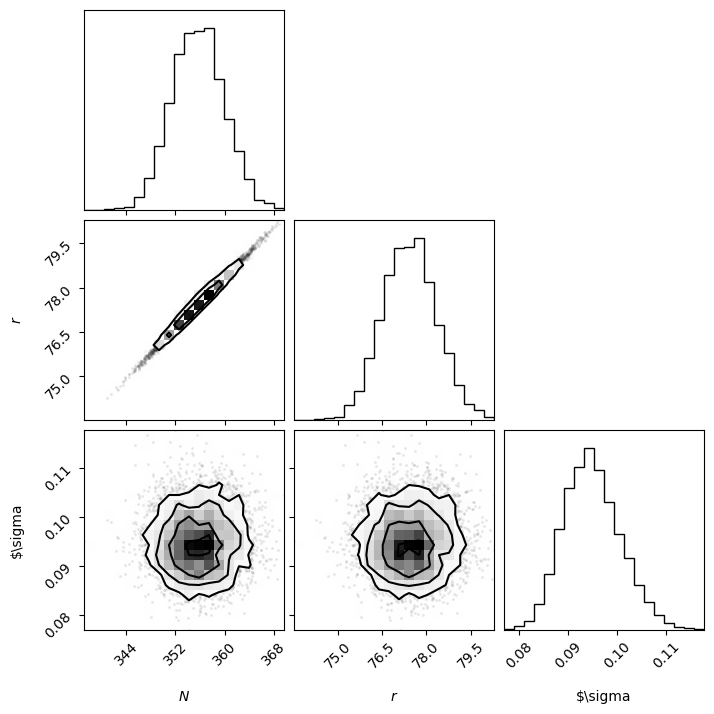

['src/mcmc_iso.pkl']

In [23]:
nuts_kernel_iso = numpyro.infer.NUTS(isomodel)
mcmc_iso = numpyro.infer.MCMC(nuts_kernel_iso, num_warmup=1000, num_samples=5000, num_chains=num_chains, progress_bar=True)
key = jax.random.PRNGKey(441)
mcmc_iso.run(key, data_vec)
samples_iso, post_samples_iso = thin_chains(mcmc_iso)

new_samples_iso = np.array(jnp.vstack((post_samples_iso['N'],
                                       post_samples_iso['r'],
                                    #    *np.array([post_samples_iso['x0'][:, i] for i in range(post_samples_iso['x0'].shape[1])]),
                                    #    *np.array([post_samples_iso['y0'][:, i] for i in range(post_samples_iso['y0'].shape[1])]),
                                    #    *np.array([post_samples_iso['alpha'][:, i] for i in range(post_samples_iso['alpha'].shape[1])]),
                                        post_samples_iso['sigma'])).T)

mcmc_iso.print_summary()
corner.corner(new_samples_iso, labels=labels_iso)
plt.show()

joblib.dump(mcmc_iso, f'{file_path}/mcmc_iso.pkl')

/home/ljf1/dis/orrery/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (15) is smaller than the number of variables to plot (21), generating only 15 plots
  warnings.warn(


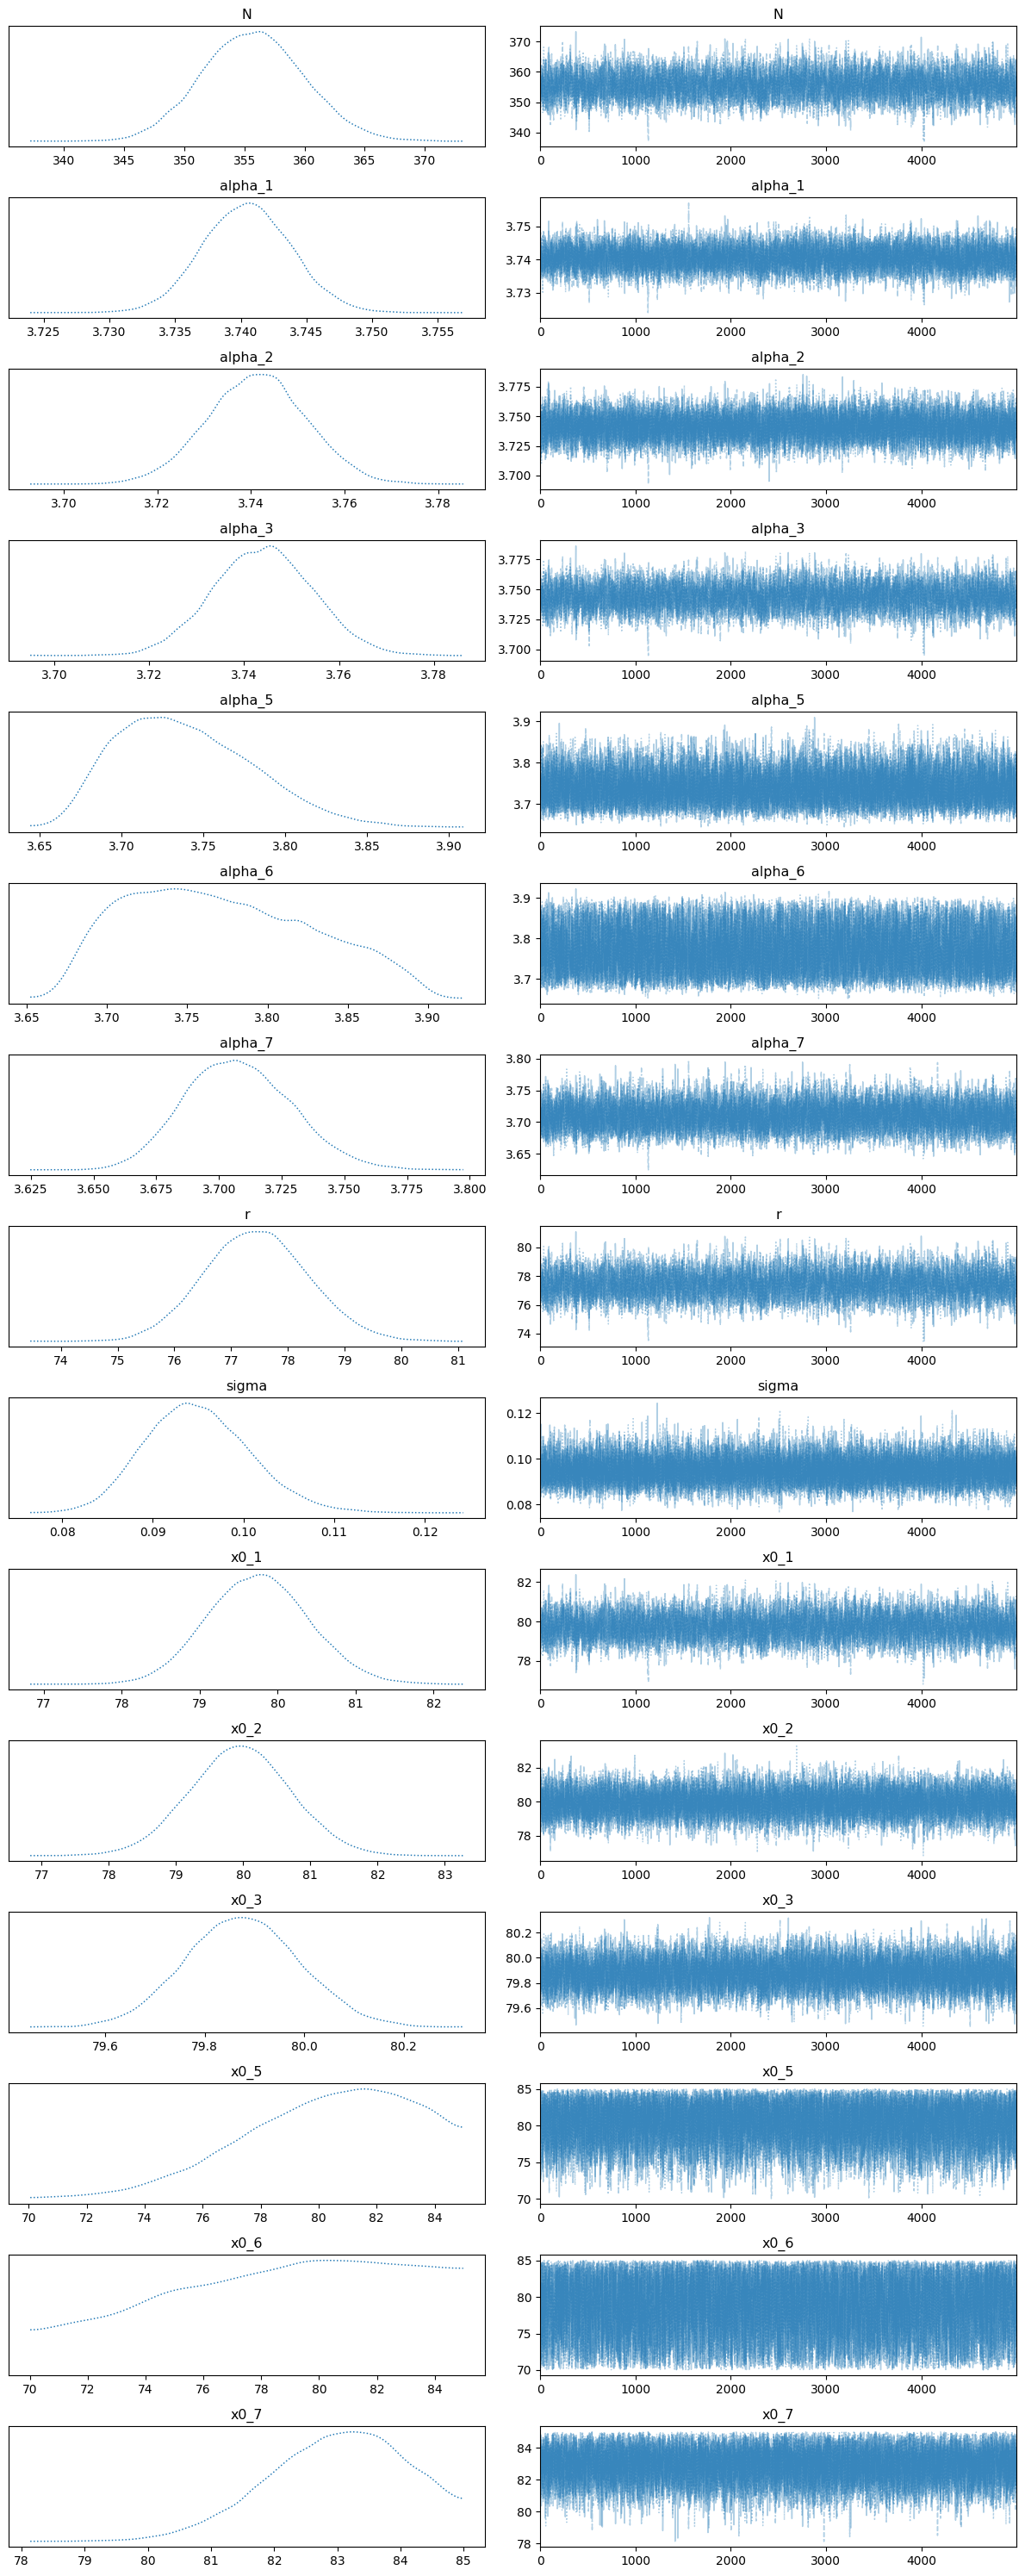

In [24]:
trace_iso = az.from_numpyro(mcmc_iso)
az.plot_trace(trace_iso, combined=True)
plt.tight_layout()
plt.show()

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]











Running chain 0:   0%|          | 0/6000 [00:08<?, ?it/s]





Running chain 0:   5%|▌         | 300/6000 [00:16<02:45, 34.39it/s]





Running chain 0:  10%|█         | 600/6000 [00:25<02:31, 35.74it/s]








Running chain 0:  15%|█▌        | 900/6000 [00:32<02:11, 38.89it/s]





Running chain 0:  20%|██        | 1200/6000 [00:40<02:06, 37.95it/s]







Running chain 0:  25%|██▌       | 1500/6000 [00:49<02:06, 35.49it/s]





Running chain 0:  30%|███       | 1800/6000 [01:01<02:15, 30.95it/s]







Running chain 0:  35%|███▌      | 2100/6000 [01:13<02:15, 28.80it/s]





Running chain 0:  40%|████      | 2400/6000 [01:22<02:00, 29.90it/s]





Running chain 0:  45%|████▌     | 2700/6000 [01:32<01:47, 30.57it/s]





Running chain 0:  50%|█████     | 3000/6000 [01:40<01:32, 32.36it/s]





Running chain 0:  55%|█████▌    | 3300/6000 [01:48<01:19, 34.03it/s]





Running chain 0:  60%|██████    | 3600/6000 [01:57<01


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.72      4.31    355.62    348.65    362.79   4920.18      1.00
   alpha_1      3.74      0.00      3.74      3.73      3.75   7633.36      1.00
   alpha_2      3.74      0.01      3.74      3.72      3.76  10727.12      1.00
   alpha_3      3.74      0.01      3.74      3.73      3.76   5024.76      1.00
   alpha_5      3.74      0.04      3.73      3.67      3.80  11643.54      1.00
   alpha_6      3.77      0.06      3.77      3.68      3.86  10486.00      1.00
   alpha_7      3.71      0.02      3.71      3.67      3.74   7100.93      1.00
         r     77.44      0.93     77.42     75.90     78.95   4906.07      1.00
   sigma_r      0.21      0.25      0.10      0.01      0.63  14875.88      1.00
   sigma_t      0.21      0.25      0.09      0.01      0.62  15742.60      1.00
      x0_1     79.76      0.66     79.74     78.67     80.84   5122.35      1.00
      x0_2     79.96      0

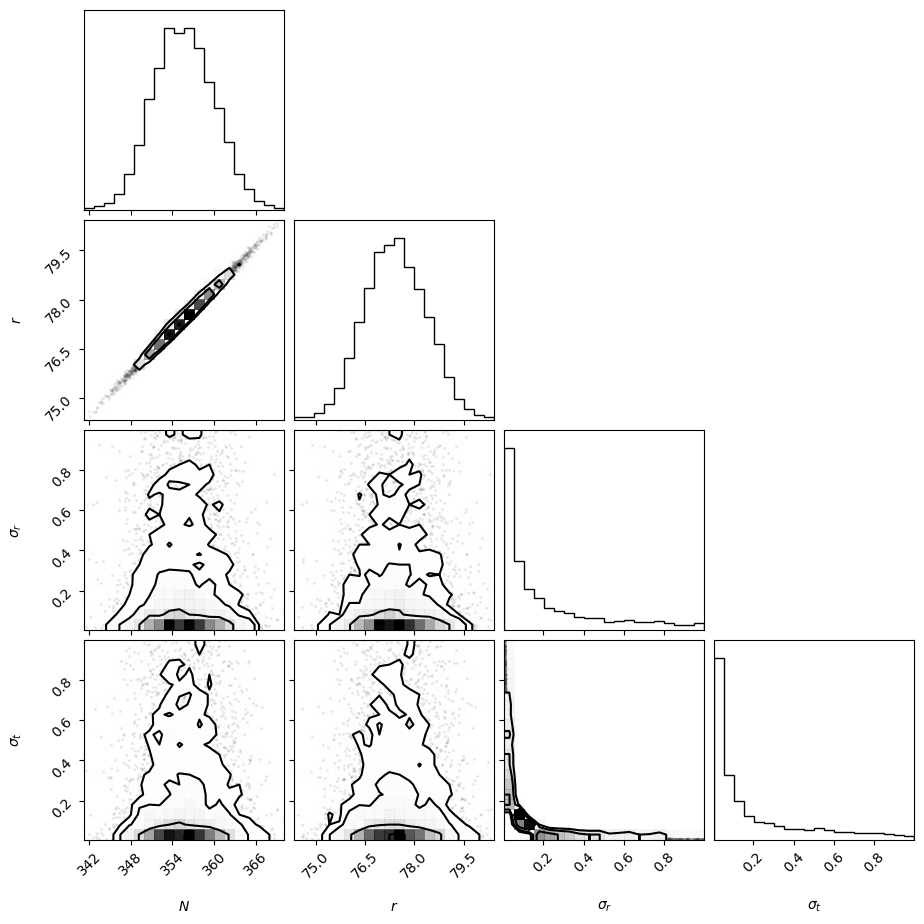

['src/mcmc_aniso.pkl']

In [25]:
key = jax.random.key(441)
nuts_kernel_aniso = numpyro.infer.NUTS(anisomodel)
mcmc_aniso = numpyro.infer.MCMC(nuts_kernel_aniso, num_warmup=1000, num_samples=5000, num_chains=num_chains, progress_bar=True)
mcmc_aniso.run(key, data_vec)
samples_aniso, post_samples_aniso = thin_chains(mcmc_aniso)
new_samples_aniso = np.array(jnp.vstack((post_samples_aniso['N'],
                                       post_samples_aniso['r'],
                                    #    *np.array([post_samples_aniso['x0'][:, i] for i in range(post_samples_aniso['x0'].shape[1])]),
                                    #    *np.array([post_samples_aniso['y0'][:, i] for i in range(post_samples_aniso['y0'].shape[1])]),
                                    #    *np.array([post_samples_aniso['alpha'][:, i] for i in range(post_samples_aniso['alpha'].shape[1])]),
                                        post_samples_aniso['sigma_r'],
                                        post_samples_aniso['sigma_t'])).T)

mcmc_aniso.print_summary()
corner.corner(new_samples_aniso, labels=labels_aniso)
plt.show()
joblib.dump(mcmc_aniso, f'{file_path}/mcmc_aniso.pkl')

In [97]:
_, _, aniso_means = thin_chains(mcmc_aniso)
_, _, iso_means = thin_chains(mcmc_iso)

/home/ljf1/dis/orrery/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (15) is smaller than the number of variables to plot (21), generating only 15 plots
  warnings.warn(


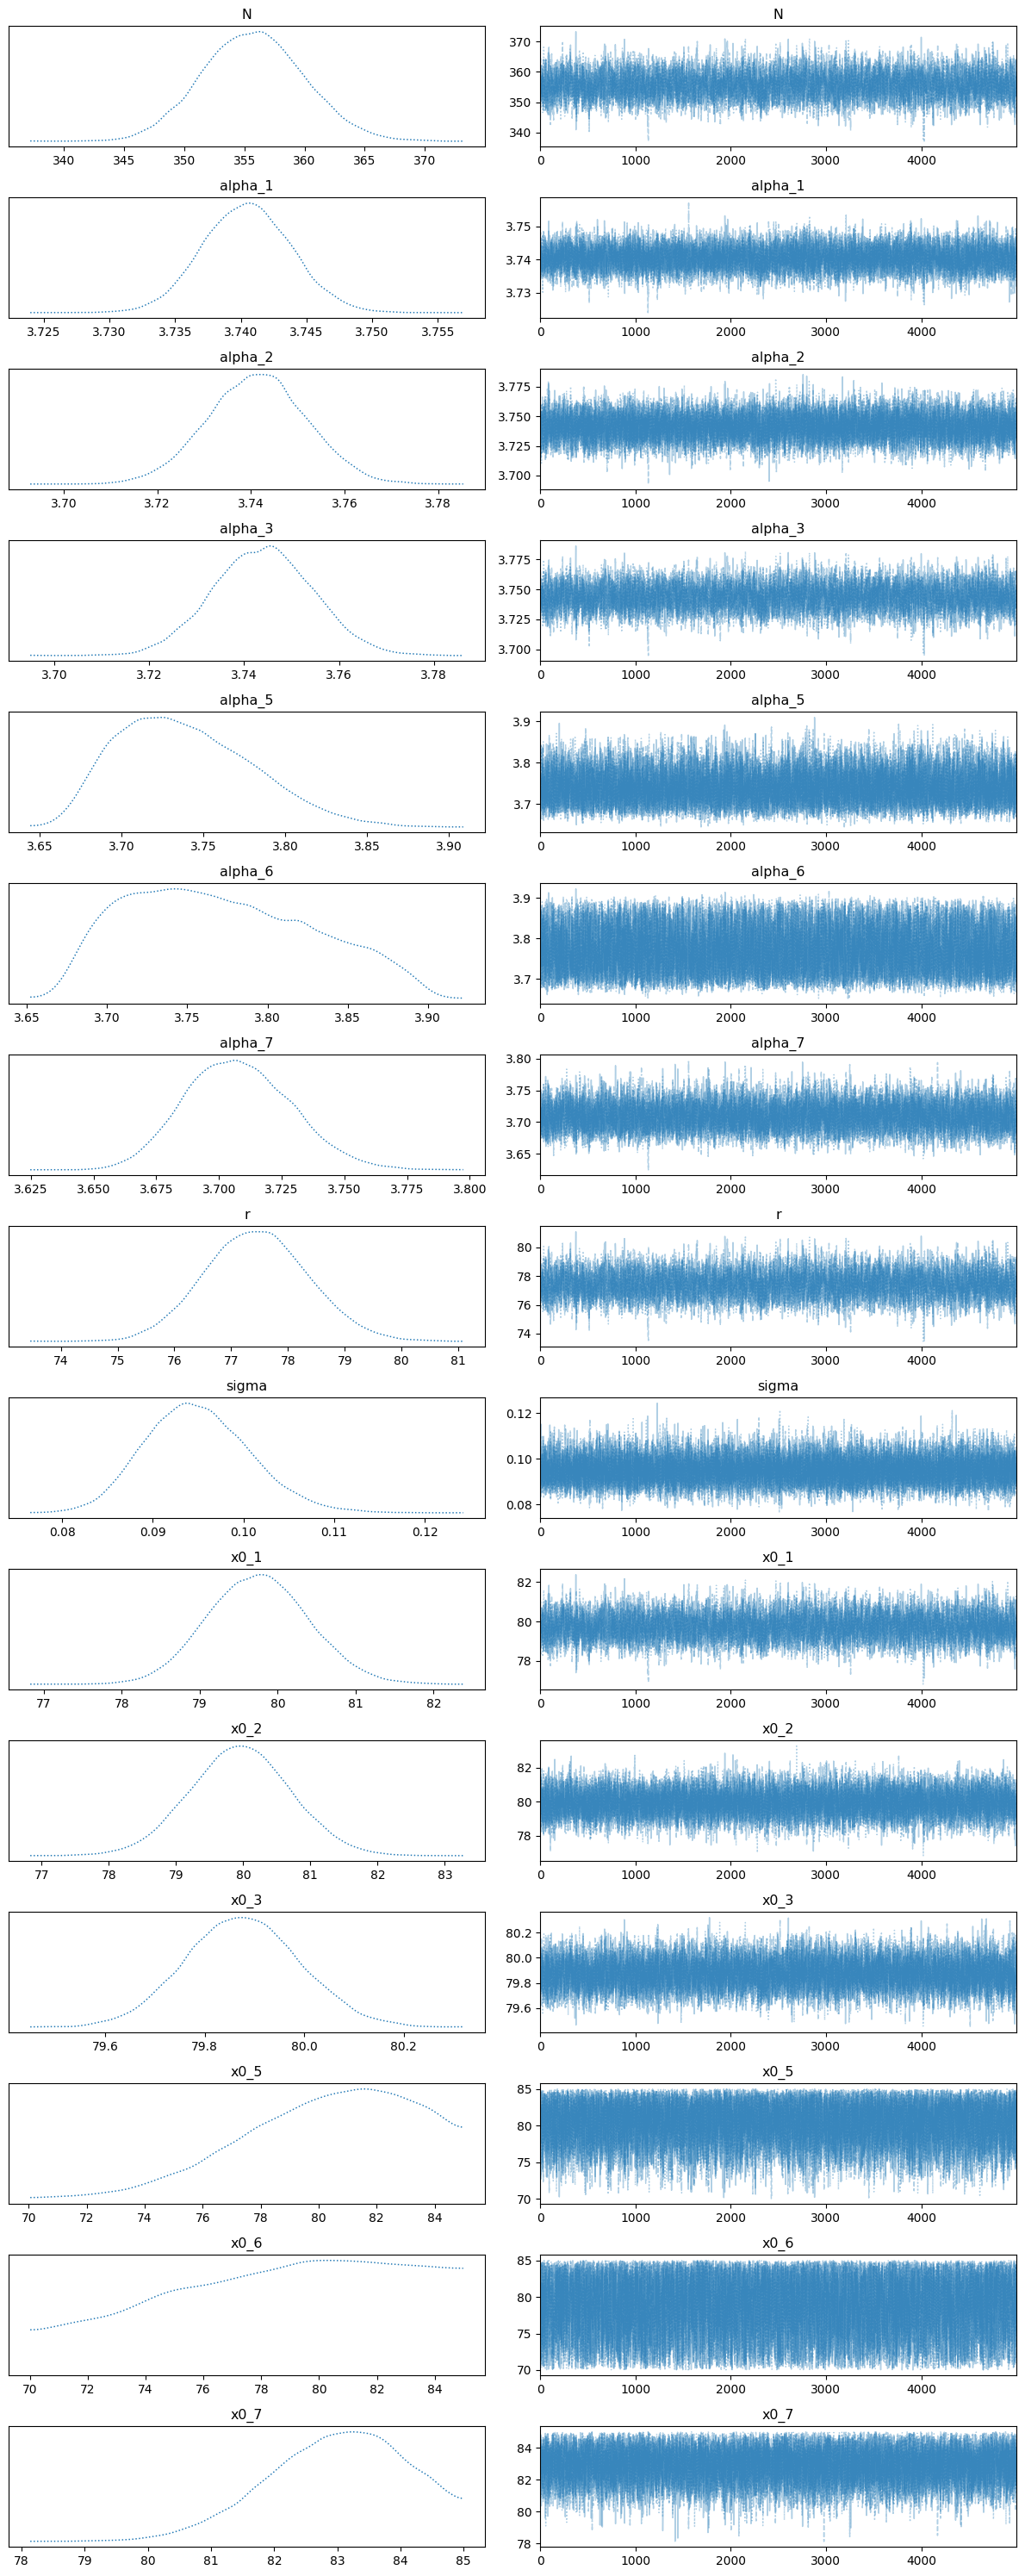

In [33]:
trace_aniso = az.from_numpyro(mcmc_aniso)
az.plot_trace(trace_iso, combined=True)
plt.tight_layout()
plt.show()

In [35]:
prediction_iso = numpyro.infer.Predictive(isomodel, post_samples_aniso)(key, data_vec)['obs']
prediction_aniso = numpyro.infer.Predictive(anisomodel, post_samples_aniso)(key, data_vec)['obs']

In [102]:
prediction_aniso*20

Array([[[-0.09524566,  3.5158706 ],
        [ 0.48751715,  2.0737646 ],
        [-0.23189384,  0.31174812],
        ...,
        [ 1.678744  ,  2.1009967 ],
        [ 1.7835236 ,  0.87964606],
        [ 2.3161783 ,  3.0375853 ]],

       [[-1.0831528 ,  3.057444  ],
        [-0.361309  ,  1.6587574 ],
        [-0.9409443 , -0.06912775],
        ...,
        [ 0.1923445 ,  2.1457224 ],
        [-0.44158074,  0.98869336],
        [-0.5602144 ,  3.2120368 ]],

       [[-1.1639845 ,  4.102945  ],
        [-0.51626825,  2.6875944 ],
        [-1.1657648 ,  0.9486182 ],
        ...,
        [ 0.8220961 ,  2.1545722 ],
        [ 0.10598492,  0.97260356],
        [-0.08106985,  3.171036  ]],

       ...,

       [[-0.38911328,  3.0222752 ],
        [ 0.25715873,  1.6125213 ],
        [-0.4011724 , -0.12142736],
        ...,
        [ 0.7319221 ,  2.5654778 ],
        [ 0.81516176,  1.3864884 ],
        [ 1.327592  ,  3.5873625 ]],

       [[ 0.8162847 ,  3.9012873 ],
        [ 1.3033266 ,  2.45

In [101]:
aniso_means

{'N': np.float32(355.71893),
 'alpha_1': np.float32(3.7404292),
 'alpha_2': np.float32(3.7413008),
 'alpha_3': np.float32(3.7440162),
 'alpha_5': np.float32(3.7388568),
 'alpha_6': np.float32(3.7717829),
 'alpha_7': np.float32(3.7079272),
 'r': np.float32(77.4436),
 'sigma_r': np.float32(0.21268582),
 'sigma_t': np.float32(0.20778717),
 'x0_1': np.float32(79.75601),
 'x0_2': np.float32(79.95523),
 'x0_3': np.float32(79.87571),
 'x0_5': np.float32(80.33452),
 'x0_6': np.float32(78.54034),
 'x0_7': np.float32(82.98677),
 'y0_1': np.float32(136.13544),
 'y0_2': np.float32(135.8057),
 'y0_3': np.float32(135.8066),
 'y0_5': np.float32(135.84178),
 'y0_6': np.float32(134.78664),
 'y0_7': np.float32(136.43365)}

In [123]:
def transform(means, prediction, q=0.5):
    r = means['r']
    N = means['N']
    alphas = jnp.array([means[f'alpha_{i}'] for i in [1, 2, 3, 5, 6, 7]])
    x0s = jnp.array([means[f'x0_{i}'] for i in [1, 2, 3, 5, 6, 7]])
    y0s = jnp.array([means[f'y0_{i}'] for i in [1, 2, 3, 5, 6, 7]])
    phis = 2*jnp.pi*(hole_ids-1)/N + alphas[remapped_section_ids]

    cos_phis = jnp.cos(phis)
    sin_phis = jnp.sin(phis)

    xij = r * cos_phis + x0s[remapped_section_ids]
    yij = r * sin_phis + y0s[remapped_section_ids]

    er = jnp.quantile(prediction[:, :, 0], q=q, axis=0)
    et = jnp.quantile(prediction[:, :, 1], q=q, axis=0)

    ex = er*jnp.cos(phis) - et*jnp.sin(phis)
    ey = er*jnp.sin(phis) + et*jnp.cos(phis)

    new_xij = xij - ex
    new_yij = yij - ey

    # print(xij, yij)
    # return xij, yij
    # return ex*20, ey*20
    return new_xij*20, new_yij*20


In [124]:
data_vec[:,0]*20

Array([ 328.83337,  346.1528 ,  363.0556 ,  379.3056 ,  396.2778 ,
        415.7222 ,  429.9444 ,  447.98618,  470.25   ,  486.25   ,
        506.3472 ,  526.41656,  549.27783,  570.625  ,  586.41656,
        608.0556 ,  632.8056 ,  655.0138 ,  679.38904,  702.18756,
        723.02783,  746.1944 ,  770.15283,  795.8612 ,  817.54156,
        841.25   ,  863.19446,  888.3056 ,  910.5    ,  936.875  ,
        964.5138 ,  992.4166 , 1016.65283, 1043.7222 , 1069.1807 ,
       1092.1943 , 1118.125  , 1142.2222 , 1167.6528 , 1194.5278 ,
       1226.5    , 1250.4584 , 1278.0693 , 1301.2778 , 1329.8057 ,
       1358.1387 , 1386.75   , 1412.0835 , 1438.236  , 1466.9445 ,
       1494.3195 , 1520.014  , 1550.6945 , 1575.25   , 1604.6807 ,
       1628.875  , 1657.639  , 1683.5278 , 1712.3334 , 1738.0555 ,
       1766.7778 , 1790.5278 , 1822.4722 , 1844.6666 , 1873.0208 ,
       1898.764  , 1928.0278 , 1950.     , 2008.1667 , 2037.6667 ,
       2060.5142 , 2100.9028 , 2123.889  , 2150.3193 , 2173.88

In [125]:
transform(aniso_means, prediction_aniso)

(Array([ 328.80957,  346.1269 ,  363.02838,  379.27612,  396.2483 ,
         415.69394,  429.91095,  447.9441 ,  470.21124,  486.21216,
         506.3037 ,  526.37634,  549.23584,  570.5791 ,  586.371  ,
         608.0037 ,  632.7479 ,  654.9517 ,  679.333  ,  702.1305 ,
         722.9717 ,  746.13904,  770.0433 ,  795.75385,  817.4344 ,
         841.1367 ,  863.0749 ,  888.1853 ,  910.37604,  936.7524 ,
         964.3983 ,  992.23047, 1016.4686 , 1043.5419 , 1068.9985 ,
        1092.0131 , 1117.9396 , 1142.0375 , 1167.4648 , 1194.3422 ,
        1226.3145 , 1250.27   , 1277.8766 , 1301.0839 , 1329.6125 ,
        1357.9414 , 1386.5533 , 1411.8855 , 1438.0364 , 1466.7412 ,
        1494.1107 , 1519.8077 , 1550.4875 , 1575.0458 , 1604.4752 ,
        1628.6718 , 1657.4384 , 1683.3241 , 1712.1307 , 1737.854  ,
        1766.5782 , 1790.3285 , 1822.2728 , 1844.4692 , 1872.8254 ,
        1898.573  , 1927.8345 , 1949.8097 , 2008.3091 , 2037.7708 ,
        2060.5942 , 2101.4802 , 2124.4421 , 2150

In [176]:
def compute_errors(means, prediction, q_low=0.05, q_high=0.95):
    xerr_lower = transform(means, prediction, q=0.5)[0] - transform(means, prediction, q=q_low)[0]
    xerr_upper = transform(means, prediction, q=q_high)[0] - transform(means, prediction, q=0.5)[0]
    yerr_lower = transform(means, prediction, q=0.5)[1] - transform(means, prediction, q=q_low)[1]
    yerr_upper = transform(means, prediction, q=q_high)[1] - transform(means, prediction, q=0.5)[1]

    xerr_lower = jnp.maximum(xerr_lower, 0)
    xerr_upper = jnp.maximum(xerr_upper, 0)
    yerr_lower = jnp.maximum(yerr_lower, 0)
    yerr_upper = jnp.maximum(yerr_upper, 0)

    return xerr_lower, xerr_upper, yerr_lower, yerr_upper

xerr_lower_aniso, xerr_upper_aniso, yerr_lower_aniso, yerr_upper_aniso = compute_errors(aniso_means, prediction_aniso)

xerr_lower_iso, xerr_upper_iso, yerr_lower_iso, yerr_upper_iso = compute_errors(iso_means, prediction_iso)

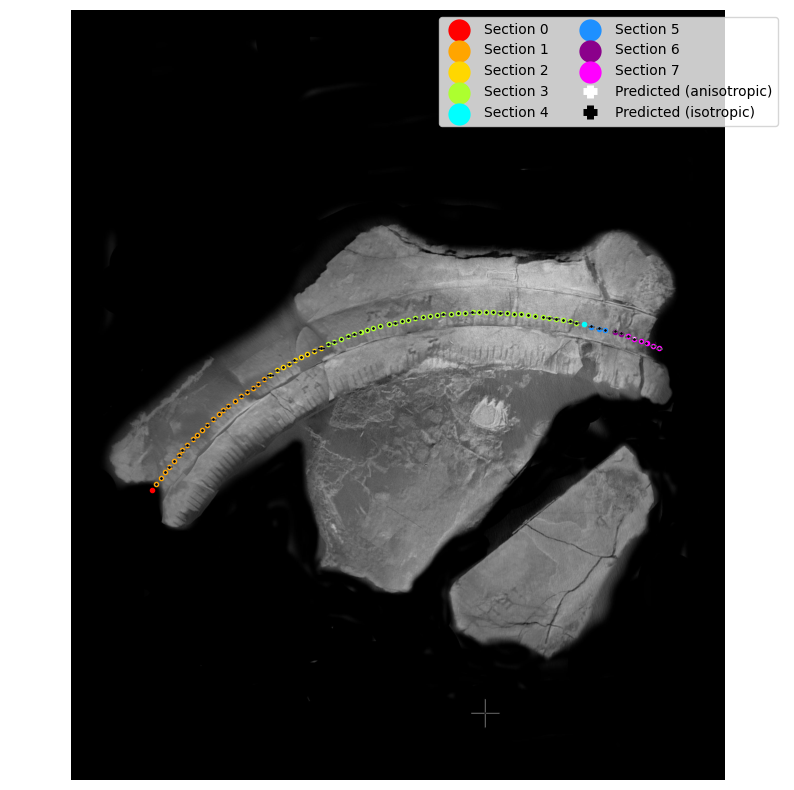

In [191]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = ["red", "orange", "gold", "greenyellow", "aqua", "dodgerblue", "darkmagenta", "fuchsia"]
ax.imshow(img, cmap='Grays_r')
for i in range(max(data['Section ID'].unique()+1)):
  section_data = data[data['Section ID'] == i]
  ax.scatter(section_data['Mean(X)']*20, section_data['Mean(Y)']*20, s = 9, color=colors[i], label=f"Section {i}")
# ax.scatter(*transform(aniso_means, prediction_aniso, q=0.5), s=7, color="white", label="Predicted (anisotropic)")
ax.errorbar(
    *transform(aniso_means, prediction_aniso, q=0.5),
    yerr=[yerr_lower_aniso, yerr_upper_aniso],
    xerr=[xerr_lower_aniso, xerr_upper_aniso],
    fmt='o',
    elinewidth=5,
    ms=1,
    color="white",
    label="Predicted (anisotropic)"
)
ax.errorbar(
    *transform(iso_means, prediction_iso, q=0.5),
    yerr=[yerr_lower_iso, yerr_upper_iso],
    xerr=[xerr_lower_iso, xerr_upper_iso],
    fmt='o',
    elinewidth=5,
    ms=1,
    color="black",
    label="Predicted (isotropic)"
)
# ax.scatter(*transform(iso_means, prediction_iso, q=0.5), s=1, color="black", label="Predicted (isotropic)")

plt.legend(ncol=2, markerscale=5)
ax.axis('equal')
ax.axis('off')
plt.show()

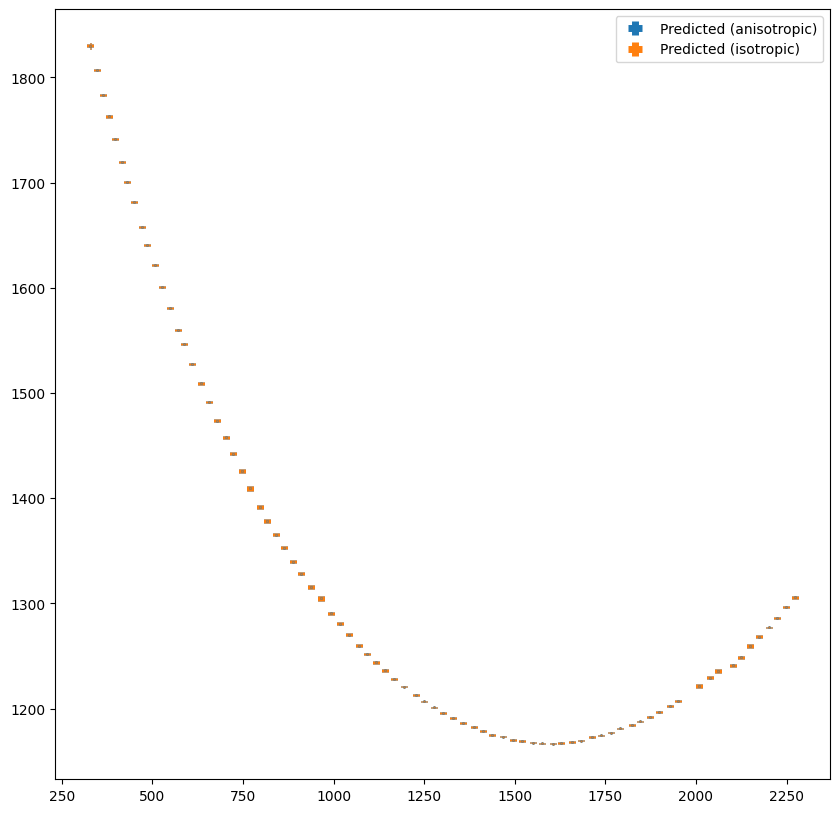

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(
    *transform(aniso_means, prediction_aniso, q=0.5),
    yerr=[yerr_lower_aniso, yerr_upper_aniso],
    xerr=[xerr_lower_aniso, xerr_upper_aniso],
    fmt='.',
    elinewidth=5,
    ms=2,
    label="Predicted (anisotropic)"
)

ax.errorbar(
    *transform(iso_means, prediction_iso, q=0.5),
    yerr=[yerr_lower_iso, yerr_upper_iso],
    xerr=[xerr_lower_iso, xerr_upper_iso],
    fmt='.',
    elinewidth=5,
    ms=1,
    label="Predicted (isotropic)"
)
# ax.axis('equal')
plt.legend()
plt.show()

In [154]:
import random

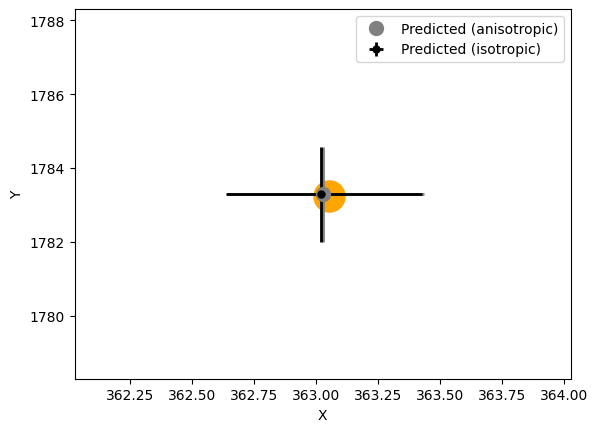

In [270]:
random_index = random.randint(0, 79 - 1)
random_index = 2
fig, ax = plt.subplots()

for i in range(max(data['Section ID'].unique()+1)):
  section_data = data[data['Section ID'] == i]
  ax.scatter(section_data['Mean(X)']*20, section_data['Mean(Y)']*20, s = 500, color=colors[i])

ax.errorbar(
    transform(aniso_means, prediction_aniso, q=0.5)[0][random_index].tolist(),
    transform(aniso_means, prediction_aniso, q=0.5)[1][random_index].tolist(),
    yerr=[[yerr_lower_aniso[random_index].tolist()], [yerr_upper_aniso[random_index].tolist()]],
    xerr=[[xerr_lower_aniso[random_index].tolist()], [xerr_upper_aniso[random_index].tolist()]],
    fmt='o',
    elinewidth=2,
    ms=10,
    color="gray",
    label="Predicted (anisotropic)"
)

ax.errorbar(
    transform(iso_means, prediction_iso, q=0.5)[0][random_index].tolist(),
    transform(iso_means, prediction_iso, q=0.5)[1][random_index].tolist(),
    yerr=[[yerr_lower_iso[random_index].tolist()], [yerr_upper_iso[random_index].tolist()]],
    xerr=[[xerr_lower_iso[random_index].tolist()], [xerr_upper_iso[random_index].tolist()]],
    fmt='o',
    elinewidth=2,
    ms=5,
    color="black",
    label="Predicted (isotropic)"
)


ax.set_xlim([transform(aniso_means, prediction_aniso, q=0.5)[0][random_index].tolist()-1, transform(aniso_means, prediction_aniso, q=0.5)[0][random_index].tolist()+1])
ax.set_ylim([transform(iso_means, prediction_iso, q=0.5)[1][random_index].tolist()-5, transform(iso_means, prediction_iso, q=0.5)[1][random_index].tolist()+5])
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

# d

In [276]:
iso_grad = jax.grad(isonll)
iso_grad(params_iso, data_vec)

Array([ 1.4309967e+00, -3.0769888e-01, -5.4883909e-01,  4.8429675e-02,
        9.2479074e-01,  9.6169069e-02,  6.3248992e-02,  1.9285738e-01,
       -4.8596230e-01, -1.8747456e-02, -2.3672685e-01, -4.1937463e-02,
       -3.0030426e-02, -1.0177669e-01, -6.7886600e+00,  4.4779234e+00,
        7.0094162e+01,  6.2930174e+00,  3.8648448e+00,  1.0503437e+01,
        1.5744705e+02], dtype=float32)

In [274]:
aniso_grad = jax.grad(anisonll)
aniso_grad(params_aniso, data_vec)

Array([ 1.4309967e+00, -3.0769888e-01, -5.4883909e-01,  4.8429675e-02,
        9.2479074e-01,  9.6169069e-02,  6.3248992e-02,  1.9285738e-01,
       -4.8596230e-01, -1.8747456e-02, -2.3672685e-01, -4.1937463e-02,
       -3.0030426e-02, -1.0177669e-01, -6.7886600e+00,  4.4779234e+00,
        7.0094162e+01,  6.2930174e+00,  3.8648448e+00,  1.0503437e+01,
        7.8946800e+01,  7.8500259e+01], dtype=float32)

# e

In [32]:
import dynesty

In [278]:
def prior_transform(u):
    r = u[0] * (r_range[1] - r_range[0]) + r_range[0]
    N = u[1] * (N_range[1] - N_range[0]) + N_range[0]
    x1 = u[2] * (x_range[1] - x_range[0]) + x_range[0]
    x2 = u[3] * (x_range[1] - x_range[0]) + x_range[0]
    x3 = u[4] * (x_range[1] - x_range[0]) + x_range[0]
    x5 = u[5] * (x_range[1] - x_range[0]) + x_range[0]
    x6 = u[6] * (x_range[1] - x_range[0]) + x_range[0]
    x7 = u[7] * (x_range[1] - x_range[0]) + x_range[0]
    y1 = u[8] * (y_range[1] - y_range[0]) + y_range[0]
    y2 = u[9] * (y_range[1] - y_range[0]) + y_range[0]
    y3 = u[10] * (y_range[1] - y_range[0]) + y_range[0]
    y5 = u[11] * (y_range[1] - y_range[0]) + y_range[0]
    y6 = u[12] * (y_range[1] - y_range[0]) + y_range[0]
    y7 = u[13] * (y_range[1] - y_range[0]) + y_range[0]
    alpha1 = u[14] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    alpha2 = u[15] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    alpha3 = u[16] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    alpha5 = u[17] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    alpha6 = u[18] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    alpha7 = u[19] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    sigma = u[20] * (sigma_range[1] - sigma_range[0]) + sigma_range[0]

    return jnp.array([r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7,
                      alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma])


In [ ]:
def iso_neg_log_likelihood(r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma):
  """ Negative log-likelihood function to minimize. """
  params = r, N, x1, x2, x3, x5, x6, x7, y1, y2, y3, y5, y6, y7, alpha1, alpha2, alpha3, alpha5, alpha6, alpha7, sigma
  return isonll(params, data_vec)

In [280]:
dynesty_sampler = dynesty.NestedSampler(isonll, prior_transform, ndim=21, nlive=100)

Exception while calling loglikelihood function:
  params: [7.88603821e+01 3.36520050e+02 7.44946594e+01 7.81591797e+01
 7.17294159e+01 7.95306396e+01 7.83191376e+01 7.34045715e+01
 1.23838684e+02 1.35522751e+02 1.46790070e+02 1.08222221e+02
 1.15492142e+02 1.31456238e+02 1.78903711e+00 1.53387392e+00
 4.96021557e+00 3.67115235e+00 1.97365379e+00 1.92481863e+00
 9.55513790e-02]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/ljf1/dis/orrery/lib/python3.12/site-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: isonll() missing 1 required positional argument: 'data'


TypeError: isonll() missing 1 required positional argument: 'data'